In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()
        self.num_params = num_params
        self.init_params()

    def init_params(self):
        if num_params == 4:
            h_base = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d_base = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T_base = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h_base = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d_base = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T_base = torch.tensor([-0.9802, 0.2283, 4.0217, 1.5428, 0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h_base = torch.tensor([1.1507, 1.9843, 4.1558, 2.2380, 1.1598, 1.1832, 0.6838, 0.9808, 0.9599, 1.5397, -2.4526, 1.5903])
            d_base = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T_base = torch.tensor([0.5358, 2.1906, 4.5437, 2.4850, 1.3502, 0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h_base = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192, 0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d_base = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259, 0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T_base = torch.tensor([1.6926, -3.4559, 5.9155, 4.1239, -2.5486, 1.9903, 0.7669, 0.1584, -0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489, 0.3304, -3.6109])

        # Use Laplace noise
        self.h = nn.Parameter(h_base + torch.distributions.Laplace(0, 0.0001).sample(h_base.size()))
        self.d = nn.Parameter(d_base + torch.distributions.Laplace(0, 0.0001).sample(d_base.size()))
        self.T = nn.Parameter(T_base + torch.distributions.Laplace(0, 0.0001).sample(T_base.size()))
    
    def add_noise(self):
        self.h.data += torch.distributions.Laplace(0, 0.0001).sample(self.h.size())
        self.d.data += torch.distributions.Laplace(0, 0.0001).sample(self.d.size())
        self.T.data += torch.distributions.Laplace(0, 0.0001).sample(self.T.size())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

Epoch 1/20000, Loss: 0.12474413216114044
Epoch 1001/20000, Loss: 0.12474403530359268
Epoch 2001/20000, Loss: 0.1247420608997345
Epoch 3001/20000, Loss: 0.07710195332765579
Epoch 4001/20000, Loss: 0.07600494474172592
Epoch 5001/20000, Loss: 0.07603240013122559
Epoch 6001/20000, Loss: 0.07601475715637207
Epoch 7001/20000, Loss: 0.07601843774318695
Epoch 8001/20000, Loss: 0.07604426145553589
Epoch 9001/20000, Loss: 0.07601239532232285
Epoch 10001/20000, Loss: 0.07600867003202438
Epoch 11001/20000, Loss: 0.07604965567588806
Epoch 12001/20000, Loss: 0.07601028680801392
Epoch 13001/20000, Loss: 0.07601460814476013
Epoch 14001/20000, Loss: 0.07602081447839737
Epoch 15001/20000, Loss: 0.07601629197597504
Epoch 16001/20000, Loss: 0.07602523267269135
Epoch 17001/20000, Loss: 0.07603003829717636
Epoch 18001/20000, Loss: 0.0760049894452095
Epoch 19001/20000, Loss: 0.07602483034133911
Loss values: [0.12474413216114044, 0.12475771456956863, 0.12475884705781937, 0.12474727630615234, 0.124748185276985

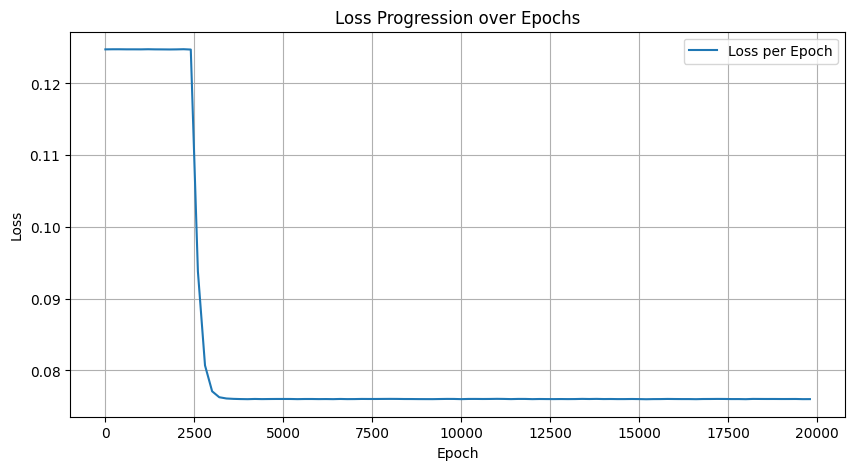

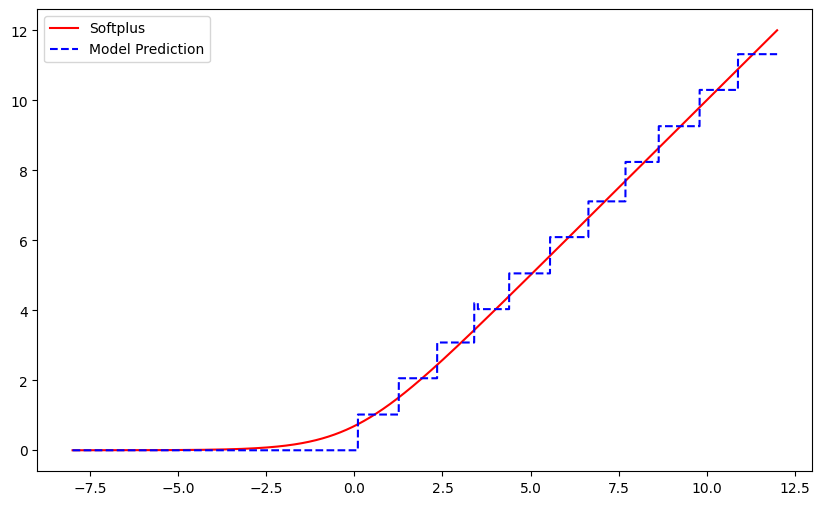

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.005820104852318764
Epoch 1001/20000, Loss: 0.005820487160235643
Epoch 2001/20000, Loss: 0.00582162057980895
Epoch 3001/20000, Loss: 0.005819639191031456
Epoch 4001/20000, Loss: 0.005820064805448055
Epoch 5001/20000, Loss: 0.005813408177345991
Epoch 6001/20000, Loss: 0.0058215283788740635
Epoch 7001/20000, Loss: 0.005823224317282438
Epoch 8001/20000, Loss: 0.005821481812745333
Epoch 9001/20000, Loss: 0.00582517683506012
Epoch 10001/20000, Loss: 0.005830224137753248
Epoch 11001/20000, Loss: 0.005820326041430235
Epoch 12001/20000, Loss: 0.005813681520521641
Epoch 13001/20000, Loss: 0.005827886983752251
Epoch 14001/20000, Loss: 0.005824034567922354
Epoch 15001/20000, Loss: 0.005819190759211779
Epoch 16001/20000, Loss: 0.005817591678351164
Epoch 17001/20000, Loss: 0.0058206780813634396
Epoch 18001/20000, Loss: 0.0058220005594193935
Epoch 19001/20000, Loss: 0.005825602915138006
Loss values: [0.005820104852318764, 0.005823188461363316, 0.005818310659378767, 0.0058138929

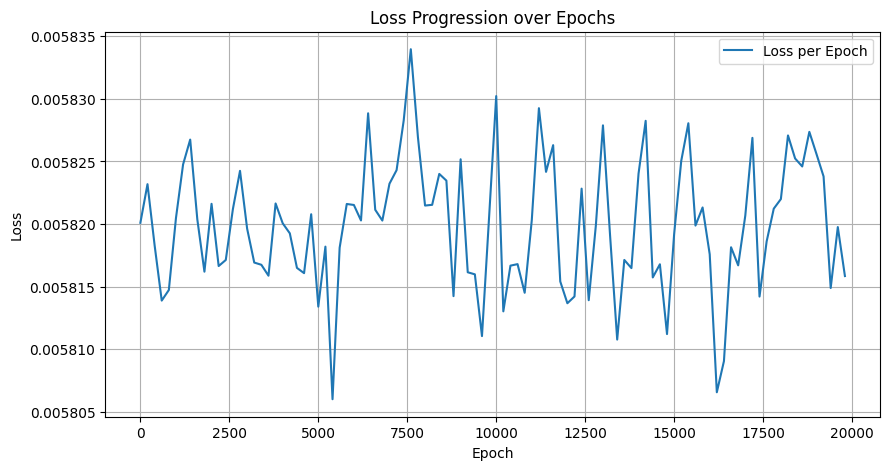

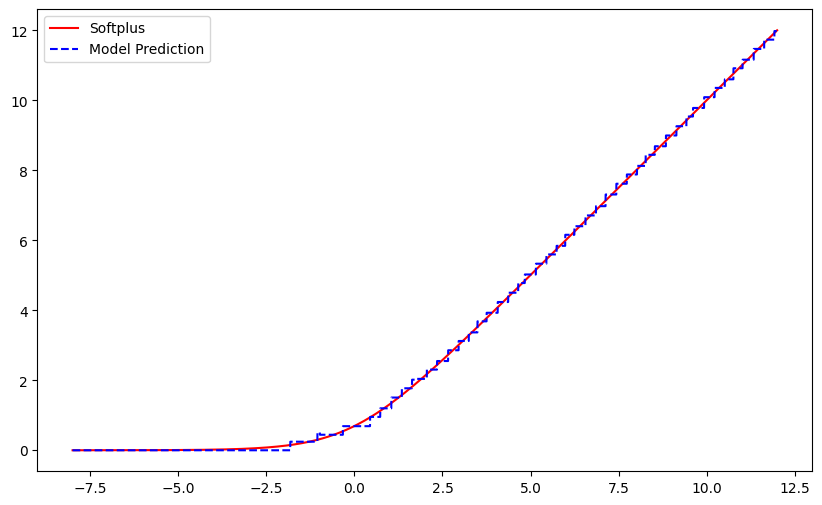

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.002248592209070921
Epoch 1001/20000, Loss: 0.0022454936988651752
Epoch 2001/20000, Loss: 0.0022155879996716976
Epoch 3001/20000, Loss: 0.0022121071815490723
Epoch 4001/20000, Loss: 0.0022053204011172056
Epoch 5001/20000, Loss: 0.002212026622146368
Epoch 6001/20000, Loss: 0.0022061127237975597
Epoch 7001/20000, Loss: 0.002212574239820242
Epoch 8001/20000, Loss: 0.0022144170943647623
Epoch 9001/20000, Loss: 0.002217120723798871
Epoch 10001/20000, Loss: 0.002225574105978012
Epoch 11001/20000, Loss: 0.002223516581580043
Epoch 12001/20000, Loss: 0.0022205037530511618
Epoch 13001/20000, Loss: 0.0022225191351026297
Epoch 14001/20000, Loss: 0.0022226430010050535
Epoch 15001/20000, Loss: 0.0022283117286860943
Epoch 16001/20000, Loss: 0.0022220751270651817
Epoch 17001/20000, Loss: 0.002226558281108737
Epoch 18001/20000, Loss: 0.0022284076549112797
Epoch 19001/20000, Loss: 0.002227373654022813
Loss values: [0.002248592209070921, 0.002243131399154663, 0.0022524651139974594, 

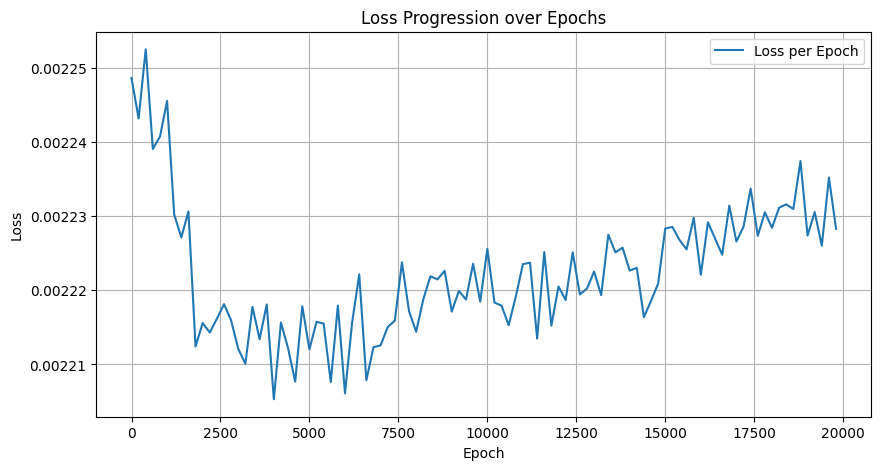

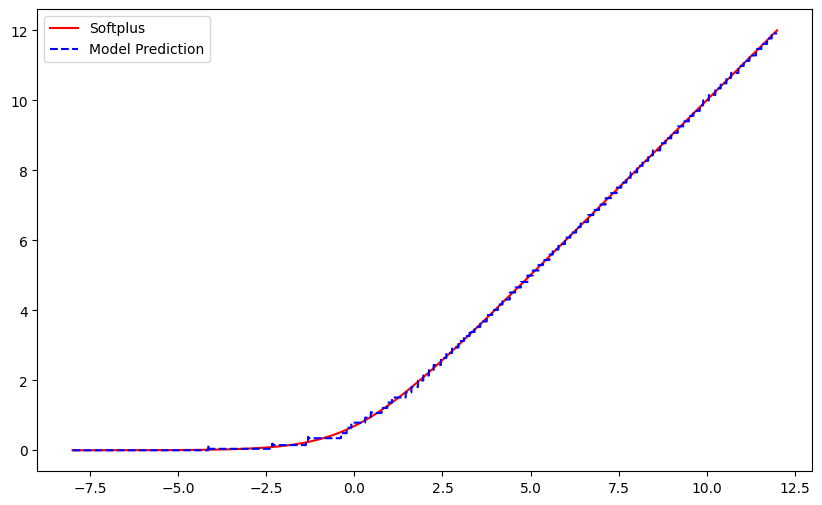

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.0009820950217545033
Epoch 1001/20000, Loss: 0.001026303507387638
Epoch 2001/20000, Loss: 0.0009934690315276384
Epoch 3001/20000, Loss: 0.0008934285142458975
Epoch 4001/20000, Loss: 0.000824562506750226
Epoch 5001/20000, Loss: 0.0007075640605762601
Epoch 6001/20000, Loss: 0.0006636787438765168
Epoch 7001/20000, Loss: 0.0007333249086514115
Epoch 8001/20000, Loss: 0.0007193165365606546
Epoch 9001/20000, Loss: 0.0006902480381540954
Epoch 10001/20000, Loss: 0.000708978099282831
Epoch 11001/20000, Loss: 0.000697469396982342
Epoch 12001/20000, Loss: 0.0006553863640874624
Epoch 13001/20000, Loss: 0.000850810029078275
Epoch 14001/20000, Loss: 0.0008822061354294419
Epoch 15001/20000, Loss: 0.0008506271406076849
Epoch 16001/20000, Loss: 0.0007944348617456853
Epoch 17001/20000, Loss: 0.0007992370519787073
Epoch 18001/20000, Loss: 0.0008157239644788206
Epoch 19001/20000, Loss: 0.0008891812176443636
Loss values: [0.0009820950217545033, 0.000995779992081225, 0.00108126096893101

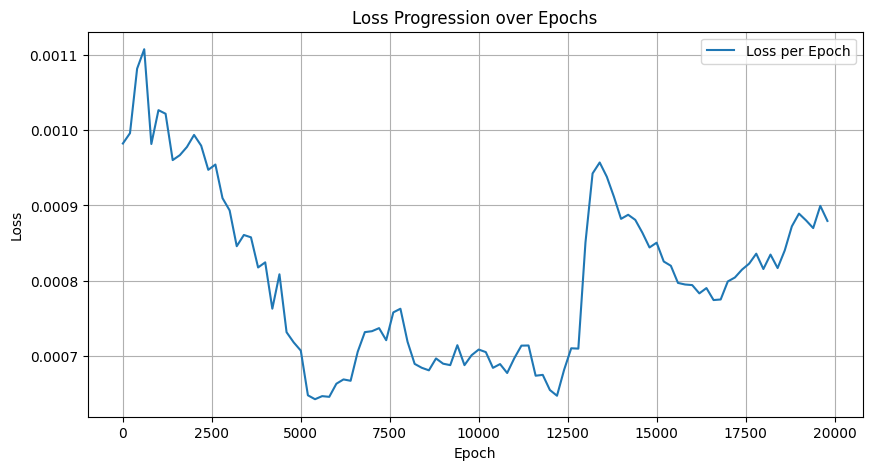

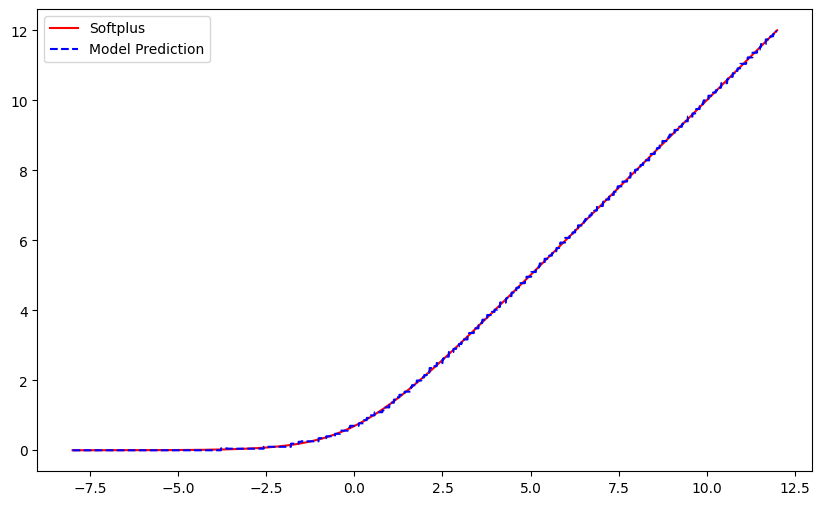

In [7]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    model.add_noise()
    
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')


# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Softplus', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.legend()

plt.show()